In [1275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

In [1276]:
from Battery_dispatch_function import BatteryDispatch

In [1277]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [1278]:
os.chdir('/home/MA')

## Define Parameter

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [1279]:
grid_emissions_CH= 181.5 # g CO2/kWh

In [1280]:
battery_sizes = [0, 6, 12, 18, 24, 30]

In [1281]:
conv_eff = 0.17 # 2020 slide 7 on https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/Photovoltaics-Report.pdf

Define PV sizing **HERE**

In [1282]:
PV_size = 6 #kW_p

According to https://www.energieheld.de/solaranlage/photovoltaik and https://www.energieheld.ch/solaranlagen/photovoltaik#:~:text=Rechnen%20Sie%20im%20Durchschnitt%20etwa,dieser%20Gr%C3%B6sse%20installieren%20zu%20k%C3%B6nnen, 6 m2 are required per kW_p

In [1283]:
size = 6*PV_size # m2 necessary for 6 kW_p

In [1284]:
HW_boiler_eff = 1
HP_COP = 3.1
AC_EER = 8.5

In [1286]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [1287]:
eta_discharge = 0.85

In [1288]:
PV_lifetime = 25 #years

In [1289]:
battery_lifetime = 15 # years

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [1290]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [1291]:
CO2_intensity_China = 637

In [1292]:
electricity_PV_production = 1597 # kWh_el kWp-1

Methodology based on this paper: https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

Get local data from https://re.jrc.ec.europa.eu/pvg_tools/en/#HR
for years 2010-2016 to average yearly variability
Solar panels were assumed to be 46 inclined towards south to maximize yearly yield without the need for sophisticated mechanic installations.

Read data into dataframe

In [1293]:
meteo_data = pd.read_csv('Data/timeseries_ZRH.csv')

In [1294]:
load = pd.read_csv('Data/household_data_60min.csv')

In [1295]:
load['Date/Time'] = pd.to_datetime(load['Date/Time'], format=' %m/%d  %H:%M:%S')

In [1296]:
load = load.set_index([load['Date/Time'].dt.month, load['Date/Time'].dt.day, load['Date/Time'].dt.hour])

In [1297]:
load.index.names = ["month", "day", "hour"]

In [1298]:
load['Electricity demand [kWh](Hourly) '] = load['Electricity demand [J](Hourly) ']/3600000 

In [1299]:
load['Electricity for Space Heating [kWh]'] = load['Space Heating demand [J](Hourly)']/HP_COP/3600000

In [1300]:
load['Electricity for Hot Water [kWh]'] = load['Hot water demand [J](Hourly)']/HW_boiler_eff/3600000

In [1301]:
load['Electricity for Space Cooling [kWh]'] = load['Space cooling demand [J](Hourly)']/AC_EER/3600000

In [1302]:
load['Total Electricity'] = load['Electricity demand [kWh](Hourly) '] + load['Electricity for Space Heating [kWh]'] + load['Electricity for Hot Water [kWh]'] + load['Electricity for Space Cooling [kWh]']

Let's also compare loads where no AC is installed, which is the current state of most Swiss homes

In [1303]:
load['Total Electricity without AC'] = load['Electricity demand [kWh](Hourly) '] + load['Electricity for Space Heating [kWh]'] + load['Electricity for Hot Water [kWh]']

**Filter here for building type!**

In [1304]:
load_SFH = load[load['Building_type']=='SFH']

In [1305]:
load_SFH_modern = load_SFH.loc[load_SFH['Construction_period'] == '2011-2015']

In [1306]:
len(load_SFH_modern)

17520

In [1307]:
load_SFH_modern_full_retrofit = load_SFH_modern.loc[load_SFH_modern['retrofit_scenario'] == 'Full retrofit']

In [1308]:
load_SFH_modern_no_retrofit = load_SFH_modern.loc[load_SFH_modern['retrofit_scenario'] == 'No retrofit']

In [1309]:
total_elec_load = load_SFH_modern_full_retrofit['Total Electricity']

Convert time column to datetime format to facilitate data processing

In [1310]:
meteo_data['time'] = pd.to_datetime(meteo_data['time'], format='%Y%m%d:%H%M')

Get rid of leap years

In [1311]:
meteo_data = meteo_data[~((meteo_data.time.dt.month == 2) & (meteo_data.time.dt.day == 29))]

Check length of dataset to be 7 years x 365 days/year x 24 hours/day = 61320 days

In [1312]:
len(meteo_data)

61320

Check date of maximum value

In [1313]:
meteo_data[meteo_data['G(i)'] == meteo_data['G(i)'].max()]

,time,G(i),H_sun,T2m,WS10m,Int
28236,2013-03-22 12:10:00,1110.61,42.48,11.17,3.6,0


This is the absolute amount of radiation incident on a solar cell in Zurich without accounting for the conversion efficiency. 
As expected, it occurs on the 22th of March, the date where the sun's angle is exactly perpendicular to the panel's orientation.

In [1314]:
meteo_data.time.dt.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [1315]:
year = 2016

In [1316]:
meteo_data = meteo_data[meteo_data.time.dt.year == year]
hourly_average=meteo_data.groupby([meteo_data["time"].dt.month, meteo_data["time"].dt.day, meteo_data["time"].dt.hour]).mean()
hourly_average.index.names = ["month", "day", "hour"]
hourly_average['Prod/m2'] = hourly_average['G(i)']*0.17/1000
hourly_average['Prod'] = hourly_average['Prod/m2']*size
yearly_PV_prod = hourly_average['Prod'].sum()
PV_production = hourly_average['Prod']
power_balance = pd.DataFrame()
power_balance['consumption'] = total_elec_load
power_balance['from PV'] = PV_production
power_balance['exchange grid'] = PV_production - total_elec_load
power_balance['to Grid'] = (PV_production - total_elec_load).clip(lower=0)
power_balance['from Grid'] = (total_elec_load - PV_production).clip(lower=0)
power_balance = power_balance.fillna(0)

## CO$_2$ calculations

### CO2 savings of PV only

Yearly energy self consumed, therefore reduced consumption from grid

In [1317]:
self_consumption_kWh = sum(power_balance['consumption'] - power_balance['from Grid'])

In [1318]:
total_CO2_PV_prod = electricity_PV_production * PV_size * CO2_intensity_China

In [1319]:
reduced_CO2_PV_g = grid_emissions_CH * self_consumption_kWh * PV_lifetime - total_CO2_PV_prod

In [1320]:
reduced_CO2_PV_t = reduced_CO2_PV_g/1000000

In [1321]:
reduced_CO2_PV_t

8.119010162371417

### CO2 savings of added batteries

In [1322]:
results = pd.DataFrame()
results['battery_size'] = battery_sizes
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [1323]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [1324]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [1325]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh
0,0,0.624686,-0,-0
1,6,0.39518,1629.24,40731
2,12,0.248861,2667.94,66698.6
3,18,0.138536,3451.13,86278.3
4,24,0.0853204,3828.9,95722.6
5,30,0.0656984,3968.2,99205


In [1326]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_CH / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [1327]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [1328]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [1329]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [1330]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [1331]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [1332]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.624686,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.39518,1629.24,40731,0.295707,7.39268,1432.5,0.912502,6.48018,0.229506
2,12,0.248861,2667.94,66698.6,0.484231,12.1058,2865.0,1.825005,10.2808,0.375825
3,18,0.138536,3451.13,86278.3,0.62638,15.6595,4297.5,2.737507,12.922,0.48615
4,24,0.0853204,3828.9,95722.6,0.694946,17.3737,5730.0,3.650010,13.7236,0.539366
5,30,0.0656984,3968.2,99205,0.720228,18.0057,7162.5,4.562513,13.4432,0.558988


In [1333]:
results.set_index("battery_size",drop=True,inplace=True)

In [1334]:
results['net_CO2_savings_with_PV'] = results['net_CO2_savings'] + reduced_CO2_PV_t

## EROI calculations

Electricity intensity used for PV production

In [1335]:
PV_production_hourly = PV_production

In [1336]:
yearly_PV_production = sum(PV_production_hourly) 

In [1337]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [1338]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [1339]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [1340]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [1341]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [1342]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [1343]:
results['ESOI'] = results['ESOI'].fillna(0)

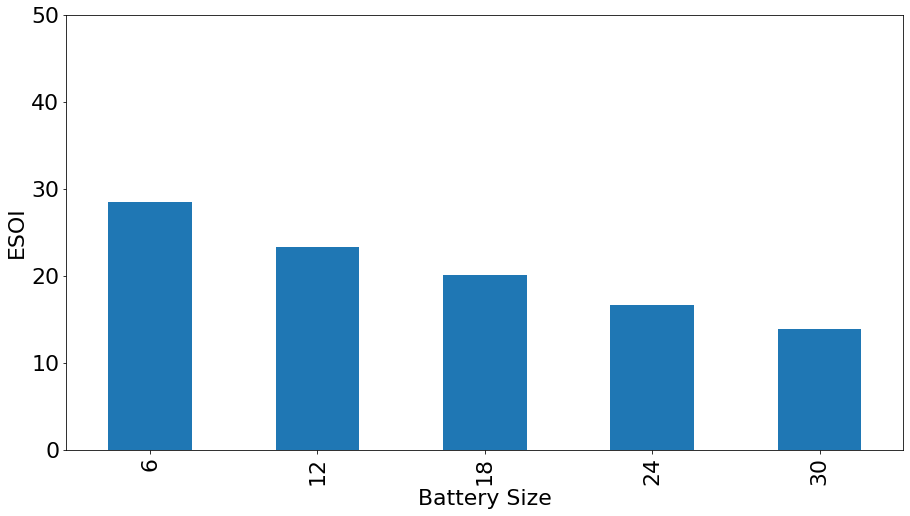

In [1344]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI', ylim = ([0, 50]));

In [1345]:
results.to_pickle('Calculations/CH/results_2016.pkl')

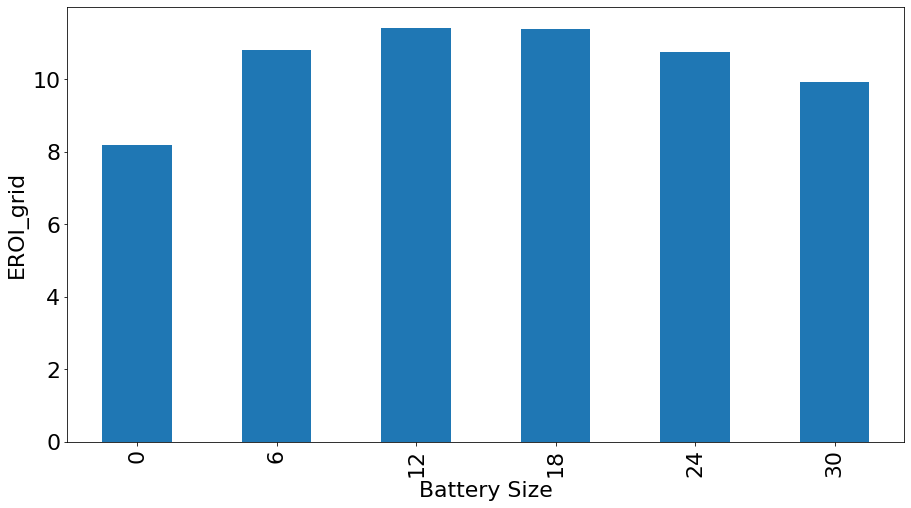

In [1346]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');

In [1347]:
curtailment_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#curtailment_thresholds = [0.4, 0.5]
battery_size = list(range(0, 25))

In [1348]:
pd.options.mode.chained_assignment = None  # default='warn'

results = pd.DataFrame()
results['curtailment'] = curtailment_thresholds
results['optimal_battery_size'] = ''    
results['net_CO2_savings'] = ''
    
for curtailment in curtailment_thresholds:
    
    temp = 0
    max_power_allowed = curtailment*PV_size
    PV_production_used = PV_production.copy()
    PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed
    PV_production_curtailed = PV_production - max_power_allowed
    PV_production_curtailed[PV_production_curtailed < 0] = 0
    power_balance = pd.DataFrame()
    power_balance['consumption'] = total_elec_load
    power_balance['from PV'] = PV_production_curtailed
    power_balance['exchange grid'] = PV_production_curtailed - total_elec_load
    power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)
    power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)
    power_balance = power_balance.fillna(0)
    
    temp = pd.DataFrame()
    temp['battery_size'] = battery_size
    temp['yearly_savings_kWh'] = ''
    temp['yearly_savings_CO2'] = ''
    temp['total_CO2_grid_reduced'] = ''
    temp['total_CO2_battery_prod'] = ''
    temp['net_CO2_savings'] = ''
    for i in range(0, len(temp['battery_size'])):
        powerbalance = BatteryDispatch(power_balance, temp['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
        temp['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
        temp['yearly_savings_CO2'].values[i] = temp['yearly_savings_kWh'].values[i] * grid_emissions_CH / 1000000
        temp['total_CO2_grid_reduced'].values[i] = temp['yearly_savings_CO2'].values[i] * PV_lifetime
        temp['total_elec_battery_prod'] = 2 * (elec_battery_prod * temp['battery_size']/0.8)
        temp['total_CO2_battery_prod'].values[i] = temp['total_elec_battery_prod'].values[i] * CO2_intensity_China / 1000000
        temp['net_CO2_savings'].values[i] =  temp['total_CO2_grid_reduced'].values[i] - temp['total_CO2_battery_prod'].values[i]
    temp_max = temp[temp['net_CO2_savings']==temp['net_CO2_savings'].max()]
    results.optimal_battery_size[results.curtailment == curtailment] = temp_max['battery_size'].values
    results.net_CO2_savings[results.curtailment == curtailment] = temp_max['net_CO2_savings'].values


In [1349]:
results.set_index("curtailment",drop=True,inplace=True)

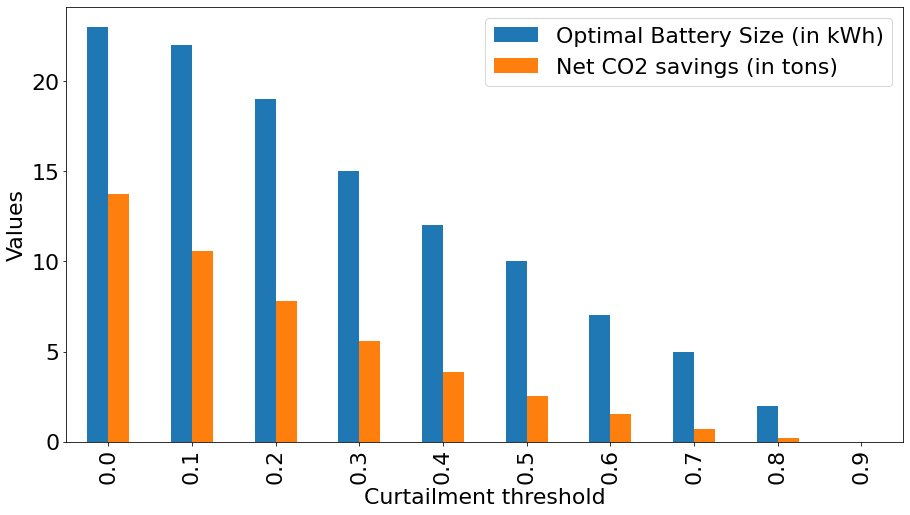

In [1350]:
results.rename(columns={"optimal_battery_size": "Optimal Battery Size (in kWh)", "net_CO2_savings": "Net CO2 savings (in tons)"}).plot.bar(xlabel = 'Curtailment threshold', ylabel = 'Values');

In [1351]:
results

,optimal_battery_size,net_CO2_savings
curtailment,,
0.0,23,13.7258
0.1,22,10.5681
0.2,19,7.77895
0.3,15,5.56283
0.4,12,3.83903
0.5,10,2.5229
0.6,7,1.51835
0.7,5,0.724579
0.8,2,0.185855


In [1352]:
results.to_pickle('Calculations/CH/results_optimization_2016.pkl')